# Analyse de la performance des modèles entrainés

Différents angles à analyser :
- Existe des classes présentes en nombre mais tout de même mal prédites ?
- A quoi resemble les libellés des classes mal prédites ? Ressemblent-ils à d'autres ? 
- Quelles sont les classes qui sont prédites avec les plus fortes/faibles proba ?
- Est-ce que les erreurs sont faites seulement lorsque la probab associée est faible ou non ?

In [1]:
import sys

import mlflow
import pandas as pd
import yaml

from constants import TEXT_FEATURE, Y
from fasttext_classifier.fasttext_evaluator import FastTextEvaluator
from fasttext_classifier.fasttext_preprocessor import FastTextPreprocessor
from fasttext_classifier.fasttext_trainer import FastTextTrainer
from fasttext_classifier.fasttext_wrapper import FastTextWrapper
from utils import get_root_path
from tqdm import tqdm

import dask.bag as db
import fasttext
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
preprocessor = FastTextPreprocessor()

In [3]:
df = pd.read_parquet("../data/extraction_sirene_20220602.parquet", engine="pyarrow")
df = df.sample(frac=0.01, random_state=1)
config_path = "config/config_fasttext22.yaml"
with open(get_root_path() / config_path, "r") as stream:
    config = yaml.safe_load(stream)
params = config["params"]
categorical_features = config["categorical_features"]

In [4]:
df_train, df_test, df_gu = preprocessor.preprocess(
    df=df,
    y=Y,
    text_feature=TEXT_FEATURE,
    categorical_features=categorical_features,
)

In [5]:
df_naf = pd.read_csv(r"../data/naf_extended.csv", dtype=str)
df_naf.set_index("NIV5", inplace=True, drop=False)

In [6]:
df_prepro = pd.concat([df_train, df_test, df_gu])
df_prepro = preprocessor.get_aggregated_APE(df_prepro, Y)

## 1) Détection des mots non-informatifs

__On cherche à détecter les mots qui sont très fréquents dans la base de données et le plus indépendant possible des différentes classes afin de construire un ``dictionnaire de mots`` à retirer.__

In [73]:
b = db.from_sequence(df_prepro["LIB_SICORE"])

__On récupère les 3000 mots les plus fréquents dans notre base de données__

In [74]:
wordcount = (
    b.str.split()  # split into words
    .flatten()  # chain all words lists
    .frequencies()  # compute occurences
    .topk(3000, lambda x: x[1])
)  # sort and return top 3000 words

list = wordcount.compute()  # Run all tasks and return result

__On calcule le kurtosis de la distribution de chaque mot afin de savoir si un mot est présent dans beaucoup ou peu de classes différentes__

In [76]:
ListofWords = sorted(set([word for word, _ in list]))
df_word = pd.DataFrame(
    {
        word: df_prepro["APE_NIV1"][df_prepro["LIB_SICORE"].str.contains("\\b" + word + "\\b")]
        .value_counts(normalize="true")
        .kurtosis()
        for word in tqdm(ListofWords)
    }.items(),
    columns=["Words", "Kurtosis"],
)
df_word = df_word.dropna().sort_values(by=["Kurtosis"]).reset_index(drop=True)

100%|██████████| 5/5 [01:16<00:00, 15.30s/it]


In [72]:
df_word

,Words,Kurtosis
0,tels,-6.000000
1,physique,-6.000000
2,mecanique,-6.000000
3,individuel,-6.000000
4,etablissement,-6.000000
...,...,...
333,achat,7.817924
334,place,9.000000
335,service,9.810623
336,services,10.607062


In [13]:
df_word.Words.to_list()

['illustrations',
 'levage',
 'preponderance',
 'dactivites',
 'utilisation',
 'decors',
 'trottinettes',
 'licences',
 'contre',
 'personnalise',
 'fourniture',
 'serv',
 'cadastre',
 'collectif',
 'jour',
 'celui',
 'traitement',
 'signaletique',
 'lorganisation',
 'entrepreneur',
 'inchangees',
 'enseignes',
 'in',
 'commande',
 'imprimes',
 'ordinateur',
 'ferme',
 'faire',
 'aromatherapie',
 'commercants',
 'milieu',
 'activit',
 'clients',
 'proposer',
 'activ',
 'navires',
 'lors',
 'bateau',
 'modification',
 'kbis',
 'decor',
 'tant',
 'activite',
 'tr',
 'sans',
 'principal',
 'commer',
 'parcours',
 're',
 'linguistique',
 'centre',
 'lactivite',
 'natures',
 'code',
 'anti',
 'sous',
 'domestique',
 'surface',
 'liees',
 'fraction',
 'aides',
 'lutte',
 'consistant',
 'but',
 'afin',
 'smartphones',
 'etablissement',
 'differentes',
 'conditions',
 'metier',
 'autour',
 'interventions',
 'fdj',
 'hydraulique',
 'amelioration',
 'presentation',
 'valorisation',
 'garages',
 

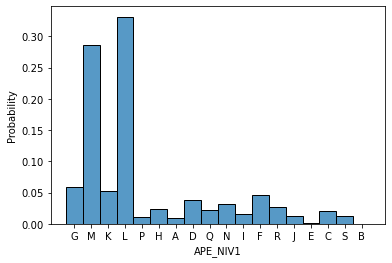

In [33]:
word = "cet"
ax = sns.histplot(
    x="APE_NIV1",
    data=df_prepro[df_prepro["LIB_SICORE"].str.contains("\\b" + word + "\\b")],
    stat="probability",
)

In [34]:
df_prepro[df_prepro["LIB_SICORE"].str.contains("\\b" + word + "\\b")].head(20)

,LIB_SICORE,AUTO,NAT_SICORE,SURF,EVT_SICORE,APE_NIV5,APE_NIV2,APE_NIV3,APE_NIV4,APE_NIV1
LIA_NUM,,,,,,,,,,
G31525177771,vente linge maison articles decoration pret po...,C,10,NaN,01M,4751Z,47,475,4751,G
C19016829379,creation graphique multimedia toutes activites...,C,12,NaN,54P,7410Z,74,741,7410,M
G84012886903,prise participation tous types societes moyens...,G,NaN,NaN,01M,6630Z,66,663,6630,K
G67520413247,activite marchands biens accomplissement toute...,C,99,NaN,54P,6810Z,68,681,6810,L
U34073164726,dessinateur publicitaire sans droit auteur non...,X,99,NaN,05P,7410Z,74,741,7410,M
G39027016777,acquisition renovation tous immeubles batis no...,C,NaN,NaN,01M,6820B,68,682,6820,L
G13532685816,fruits legumes epicerie boissons non alcoolise...,C,NaN,NaN,01M,4631Z,46,463,4631,G
M49011408763,entreprise garage vente location vehicules neu...,M,10,NaN,54P,4511Z,45,451,4511,G
C40011164841,production commercialisation oeuvres picturale...,C,NaN,NaN,11M,4778C,47,477,4778,G


__On analyse le premier quartile de cette liste de mot les plus fréquents qui contient donc les mots présents dans plusieurs classes différentes en grande proportion__

In [14]:
Top25 = df_word["Words"][df_word["Kurtosis"] < df_word.Kurtosis.quantile(0.25)].to_list()

__On construit à la main (...)  dictionnaires issus de cette liste__

In [15]:
Top25

['illustrations',
 'levage',
 'preponderance',
 'dactivites',
 'utilisation',
 'decors',
 'trottinettes',
 'licences',
 'contre',
 'personnalise',
 'fourniture',
 'serv',
 'cadastre',
 'collectif',
 'jour',
 'celui',
 'traitement',
 'signaletique',
 'lorganisation',
 'entrepreneur',
 'inchangees',
 'enseignes',
 'in',
 'commande',
 'imprimes',
 'ordinateur',
 'ferme',
 'faire',
 'aromatherapie',
 'commercants',
 'milieu',
 'activit',
 'clients',
 'proposer',
 'activ',
 'navires',
 'lors',
 'bateau',
 'modification',
 'kbis',
 'decor',
 'tant',
 'activite',
 'tr',
 'sans',
 'principal',
 'commer',
 'parcours',
 're',
 'linguistique',
 'centre',
 'lactivite',
 'natures',
 'code',
 'anti',
 'sous',
 'domestique',
 'surface',
 'liees',
 'fraction',
 'aides',
 'lutte',
 'consistant',
 'but',
 'afin',
 'smartphones',
 'etablissement',
 'differentes',
 'conditions',
 'metier',
 'autour',
 'interventions',
 'fdj',
 'hydraulique',
 'amelioration',
 'presentation',
 'valorisation',
 'garages',
 

## 2) Détection des mots perturbant la classification du modèle

Pour importer un seul modèle spécifique, il suffit de run les commandes suivantes : 

- export PYTHONPATH="$PWD:$PYTHONPATH"

- export MC_HOST_minio=https://$AWS_ACCESS_KEY_ID:$AWS_SECRET_ACCESS_KEY:$AWS_SESSION_TOKEN@$AWS_S3_ENDPOINT

- mc cp -r minio/projet-ape/mlflow-artifacts/1/1ce012ef93bc436bac951ff0f2ab7286/artifacts/default/artifacts/ models/

In [44]:
model = fasttext.load_model("../models/default.bin")
evaluator = FastTextEvaluator(model)

In [78]:
df_all = evaluator.get_aggregated_APE_dict(
    pd.concat([df_train, df_test, df_gu]), Y, TEXT_FEATURE, categorical_features
)[1]
df_all.set_index("liasseNb", inplace=True)

 80%|████████  | 4/5 [05:43<01:25, 85.88s/it]


In [79]:
df_all = df_all.join(df_prepro)

In [80]:
df_false = df_all[df_all["ground_truth"] != df_all["predictions"]]

In [81]:
b_false = db.from_sequence(df_false["LIB_SICORE"])

wordcount = (
    b_false.str.split()  # split into words
    .flatten()  # chain all words lists
    .frequencies()  # compute occurences
    .topk(3000, lambda x: x[1])
)  # sort and return top 10 words

list_false = wordcount.compute()  # Run all tasks and return result

In [82]:
ListofWords = sorted(set([word for word, _ in list_false]))
df_word_false = pd.DataFrame(
    {
        word: df_false["APE_NIV1"][df_false["LIB_SICORE"].str.contains("\\b" + word + "\\b")]
        .value_counts(normalize="true")
        .kurtosis()
        for word in tqdm(ListofWords)
    }.items(),
    columns=["Words", "Kurtosis"],
)
df_word_false = df_word_false.dropna().sort_values(by=["Kurtosis"]).reset_index(drop=True)

100%|██████████| 500/500 [00:01<00:00, 280.58it/s]


__On sélectionne les mots qui ont le kurtosis le plus faible parmi les mauvaises prédictions__

In [83]:
df_word_false["Words"][df_word_false["Kurtosis"] < df_word_false.Kurtosis.quantile(0.25)].to_list()

['tels',
 'physique',
 'mecanique',
 'individuel',
 'etablissement',
 'recuperation',
 'transformation',
 'electricite',
 'chef',
 'conseiller',
 'art',
 'artistique',
 'cartes',
 'publics',
 'affiches',
 'afin',
 'electronique',
 'marque',
 'objet',
 'plus',
 'animations',
 'papier',
 'recherche',
 'petit',
 'mesure',
 'depannage',
 'projet',
 'espace',
 'produit',
 'prise',
 'locaux',
 'exterieur',
 'accueil',
 'ape',
 'interieur',
 'animaux',
 'nettoyage',
 'ateliers',
 'reseaux',
 'multiservices',
 'intermediaire',
 'compte',
 'drone',
 'numerique',
 'formations',
 'textiles',
 'type',
 'management',
 'consultant',
 'biens',
 'preparation',
 'repas',
 'production',
 'but',
 'physiques',
 'productions',
 'vetement',
 'pierres',
 'telephone',
 'jardin',
 'renovation',
 'emporter',
 'commerciale',
 'batiments',
 'garde',
 'associations',
 'retouche',
 'clientele',
 'faire',
 'genre',
 'vehicule',
 'reparations',
 'enfants',
 'public',
 'conseil',
 'client',
 'autres',
 'sous',
 'video

__On récupère les mots les plus présents dans les liasses mal prédites qui ne font pas parti des mots les plus fréquents dans la base entière.__

In [87]:
OnlyFalse = [tup for tup in list_false if tup[0] not in [word for word, _ in list]]

__On récupère les mots les plus présents dans les liasses mal prédites et qui font également parti des mots les plus fréquents dans la base entière.__

In [88]:
BothSet = [tup for tup in list_false if tup[0] in [word for word, _ in list]]

In [100]:
BothSet_dic = dict(BothSet)
list_dic = dict(list)

In [101]:
pd.DataFrame(
    {word: BothSet_dic[word] / list_dic[word] * 100 for word, _ in tqdm(BothSet)}.items(),
    columns=["Words", "Proportions"],
)

100%|██████████| 5/5 [00:00<00:00, 53362.65it/s]


,Words,Proportions
0,vente,0.016813
1,conseil,0.014376
2,gestion,0.009663
3,location,0.006066
4,tous,0.002306
